In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-customers/BankChurners.csv


### Table of contents - 
* [What is customer churn and why is it important? 🏆](#Intro)
* [EDA 🔍](#EDA)
* [Data preprocessing - Encoding and Scaling 🛠](#prepro)
* [SMOTE and model building 🔮](#model)
* [Deep dive into the performance metrics 🏄‍ ](#fin)

### Introduction to Customer churn <a class="anchor"  id="Intro"></a>

Customer churn, also known as customer attrition, refers to the phenomenon where customers discontinue or terminate their relationship with a business or service provider. Customer churn is a critical metric for banks, impacting both their financial performance and competitive position. In this notebook, we will make use of a simple feedforward neural network (Multi layer Perception) to solve this classification problem. 

### Exploratory Data Analysis <a class="anchor"  id="EDA"></a>


In [2]:
df = pd.read_csv('/kaggle/input/credit-card-customers/BankChurners.csv')
df = df[df.columns[:-2]]
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [3]:
# Numerical and catagorical columns 

num_cols = [col for col in df.columns if df[col].dtype != 'object']
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
cat_cols.remove('Attrition_Flag')

In [4]:
# Checking for missing values 

null_df = pd.DataFrame((df.isnull().sum())*100/df.shape[0],index=df.columns,columns=['Missing %'])
null_df[null_df['Missing %']>0]

,Missing %


In [5]:
# Checking for duplicate rows 

df[df.duplicated()]

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio


In [6]:
# Distribution of the target (Attrition_Flag)

df['Attrition_Flag'].value_counts()/(len(df))

Attrition_Flag
Existing Customer    0.83934
Attrited Customer    0.16066
Name: count, dtype: float64

This is a classic problem of an imbalanced dataset with only 16% of the customers having churned. We will deal with this using SMOTE.

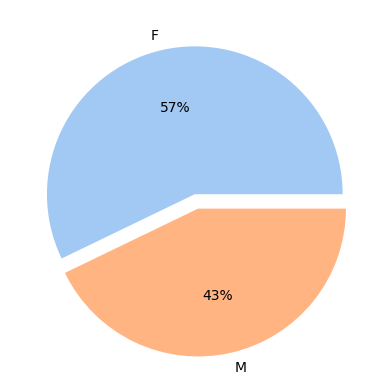

In [7]:
# Attrition based on gender

data = df[df['Attrition_Flag']=='Attrited Customer']['Gender'].value_counts()
keys = df[df['Attrition_Flag']=='Attrited Customer']['Gender'].unique()
explode = [0, 0.1]
palette_color = sns.color_palette('pastel') 
plt.pie(data, labels=keys, colors=palette_color, 
        explode=explode, autopct='%.0f%%') 
plt.show() 

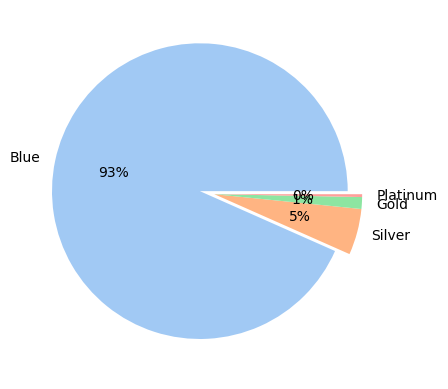

In [8]:
data = df[df['Attrition_Flag']=='Attrited Customer']['Card_Category'].value_counts()
keys = df[df['Attrition_Flag']=='Attrited Customer']['Card_Category'].unique()
explode = [0.1,0,0,0]
palette_color = sns.color_palette('pastel') 
plt.pie(data, labels=keys, colors=palette_color, 
        explode=explode, autopct='%.0f%%') 
plt.show() 

Wow! 93% of the attrited customers belong to the blue card category, whereas the more premimum category (which is not very popular) like platinum has a very small proportion of attrited customers. This is not a clear metric as the number of customers having a blue card is much higher than the customers belonging to more premimum card categories. Let us use a more reliable metric and define % attrition which is calculated using both the number of customers belonging to a card category and how many of them have churned.

In [9]:
# Attrition % based on card category

attrition_p = []
counts = df['Card_Category'].value_counts()
data = df[df['Attrition_Flag']=='Attrited Customer']['Card_Category'].value_counts()
keys = df[df['Attrition_Flag']=='Attrited Customer']['Card_Category'].unique()
for key in keys:
    print(key,(data[key]/counts[key])*100)
    attrition_p.append((data[key]/counts[key])*100)


Blue 16.097922848664687
Silver 14.774774774774773
Gold 18.103448275862068
Platinum 25.0


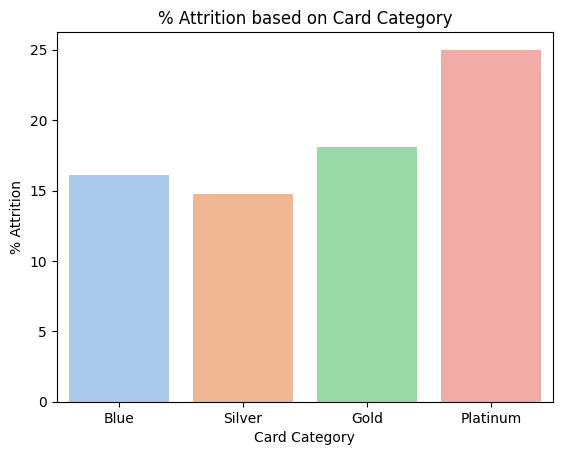

In [10]:
ax = sns.barplot(x=keys,y=attrition_p,palette='pastel')
ax.set(title='% Attrition based on Card Category',ylabel='% Attrition',xlabel='Card Category');

Now looks like the customers belonging to platinum category have a higher churn % of 25%.

### Data preprocessing - Encoding and Scaling  <a class="anchor"  id="prepro"></a>

In [11]:
# Encoding - to surpass the curse of dimensionality we will go ahead with Label encoding instead of OHE. 

from sklearn.preprocessing import LabelEncoder

for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

In [12]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,1,3,3,1,2,0,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,0,5,2,2,4,0,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,1,3,2,1,3,0,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,0,4,3,3,4,0,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,1,3,5,1,2,0,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [13]:
df.Attrition_Flag = df.Attrition_Flag.replace({'Attrited Customer':1,'Existing Customer':0})

In [14]:
# Feature scaling - Standardization

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df[num_cols] = scaler.fit_transform(df[num_cols])

In [15]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0.802878,0,-0.165406,1,0.503368,3,1,2,0,0.384621,...,-1.327136,0.492404,0.446622,-0.473422,0.488971,2.623494,-0.959707,-0.973895,3.834003,-0.775882
1,2.156861,0,0.333570,0,2.043199,2,2,4,0,1.010715,...,-1.327136,-0.411616,-0.041367,-0.366667,-0.008486,3.563293,-0.916433,-1.357340,12.608573,-0.616276
2,-0.682769,0,0.583058,1,0.503368,2,1,3,0,0.008965,...,-1.327136,-2.219655,-0.573698,-1.426858,-0.445658,8.367214,-0.740982,-1.911206,6.807864,-0.997155
3,0.832862,0,-0.789126,0,1.273283,3,3,4,0,-0.241473,...,1.641478,-1.315636,-0.585251,1.661686,-0.734100,2.942843,-0.951758,-1.911206,6.807864,1.759686
4,-0.814896,0,-0.789126,1,0.503368,5,1,2,0,-1.869317,...,-1.327136,-2.219655,-0.430877,-1.426858,-0.302868,6.455682,-1.056263,-1.570365,7.509325,-0.997155


### SMOTE and model building <a class="anchor"  id="model"></a>

In [16]:
# Creating train, val and test sets

from sklearn.model_selection import train_test_split

X = df.drop(columns = ['Attrition_Flag'],axis=1)
y = df['Attrition_Flag']

X_train, X_rem, y_train, y_rem = train_test_split(X, y,
                                                  train_size=0.70)
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem,
                                                    test_size=0.15)

In [17]:
# To deal with class imbalance and prevent overfitting we will be using SMOTE.

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense,Dropout


input_features = 20

# model creation
model = Sequential()
model.add(Dense(units=20, input_shape=(input_features,), activation='relu'))
model.add(Dropout(0.5)) # To prevent overfitting
model.add(Dense(units=11, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid')) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Epoch 1/50
372/372 [==============================] - 2s 3ms/step - loss: 0.8034 - accuracy: 0.5577 - val_loss: 0.5608 - val_accuracy: 0.8099
Epoch 2/50
372/372 [==============================] - 1s 2ms/step - loss: 0.5796 - accuracy: 0.6826 - val_loss: 0.4486 - val_accuracy: 0.8409
Epoch 3/50
372/372 [==============================] - 1s 3ms/step - loss: 0.4974 - accuracy: 0.7583 - val_loss: 0.3726 - val_accuracy: 0.8517
Epoch 4/50
372/372 [==============================] - 1s 2ms/step - loss: 0.4424 - accuracy: 0.8023 - val_loss: 0.3488 - val_accuracy: 0.8571
Epoch 5/50
372/372 [==============================] - 1s 3ms/step - loss: 0.4072 - accuracy: 0.8188 - val_loss: 0.3190 - val_accuracy: 0.8622
Epoch 6/50
372/372 [==============================] - 1s 3ms/step - loss: 0.3836 - accuracy: 0.8340 - val_loss: 0.3079 - val_accuracy: 0.8660
Epoch 7/50
372/372 [==============================] - 1s 3ms/step - loss: 0.3686 - accuracy: 0.8432 - val_loss: 0.2745 - val_accuracy: 0.8811
Epoch 

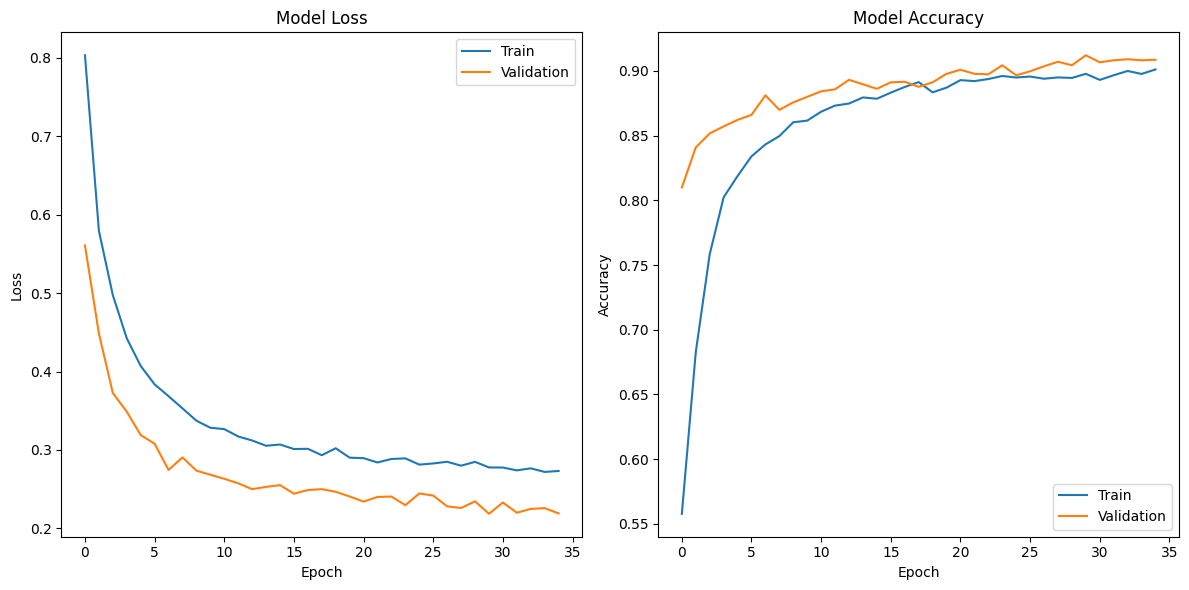

In [19]:
# Learning curve plotting

import matplotlib.pyplot as plt
from keras.callbacks import History

# Create an instance of History to store training history
history = History()

# Train the model and store the training history
model.fit(X_train_smote, y_train_smote, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping,history])

# Plot the learning curve
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.tight_layout()
plt.show()

In [20]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 0s 2ms/step - loss: 0.1728 - accuracy: 0.9298


[0.17284010350704193, 0.9298245906829834]

In [21]:
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 2ms/step


In [22]:
y_pred_c = []
for elements in y_pred:
    if elements >= 0.5:
        y_pred_c.append(1)
    else:
        y_pred_c.append(0)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,y_pred_c))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       390
           1       0.73      0.82      0.77        66

    accuracy                           0.93       456
   macro avg       0.85      0.88      0.86       456
weighted avg       0.93      0.93      0.93       456



### Deep dive into the performance metrics <a class="anchor"  id="fin"></a>

Though the overall accuracy of the model was fine, it is still crucial to consider metrics like precision, recall and f1-score. Going back to our use case -

The model is able to correctly classify a good percentage of the customers that do not churn, however based on the recall we can note that it is not completely thorough in doing so - as rightly represented by the f1-score. 

Coming to the attrited customers, it is able to correctly classify quite few which will not really be very beneficial to the company. 